### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Aug 13 02:19:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

In [2]:
!pip install -q rfdetr

## Download dataset from Roboflow Universe

In [3]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="JOOy8ib1kct8yzsUUKjz")
project = rf.workspace("ilhamrafi").project("exavator-detection-tvow1")
version = project.version(6)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


## Train RF-DETR on custom dataset

In [4]:
from rfdetr import RFDETRNano

model = RFDETRNano()
history = []

def callback2(data):
    history.append(data)

model.callbacks["on_fit_epoch_end"].append(callback2)

model.train(
            dataset_dir=dataset.location,
            epochs=25,
            batch_size=4,
            grad_accum_steps=4,
            lr=1e-4,
            early_stopping=True,
            output_dir="exavator-detection" # Nama folder untuk menyimpan hasil
            )

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing your detection head with 6 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir exavator-detection' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=6, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=25, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-nano.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=2, dim_feedforward=2048, hidden_dim=256, sa_nheads=8,

Epoch: [0]  [  0/135]  eta: 0:09:44  lr: 0.000100  class_error: 84.62  loss: 6.0448 (6.0448)  loss_ce: 1.3220 (1.3220)  loss_bbox: 0.3919 (0.3919)  loss_giou: 0.2223 (0.2223)  loss_ce_0: 1.3101 (1.3101)  loss_bbox_0: 0.4864 (0.4864)  loss_giou_0: 0.2612 (0.2612)  loss_ce_enc: 1.2926 (1.2926)  loss_bbox_enc: 0.4621 (0.4621)  loss_giou_enc: 0.2961 (0.2961)  loss_ce_unscaled: 1.3220 (1.3220)  class_error_unscaled: 84.6154 (84.6154)  loss_bbox_unscaled: 0.0784 (0.0784)  loss_giou_unscaled: 0.1112 (0.1112)  cardinality_error_unscaled: 3891.5000 (3891.5000)  loss_ce_0_unscaled: 1.3101 (1.3101)  loss_bbox_0_unscaled: 0.0973 (0.0973)  loss_giou_0_unscaled: 0.1306 (0.1306)  cardinality_error_0_unscaled: 3874.2500 (3874.2500)  loss_ce_enc_unscaled: 1.2926 (1.2926)  loss_bbox_enc_unscaled: 0.0924 (0.0924)  loss_giou_enc_unscaled: 0.1480 (0.1480)  cardinality_error_enc_unscaled: 2734.5000 (2734.5000)  time: 4.3271  data: 1.0330  max mem: 2700
Epoch: [0]  [ 10/135]  eta: 0:05:12  lr: 0.000100  clas

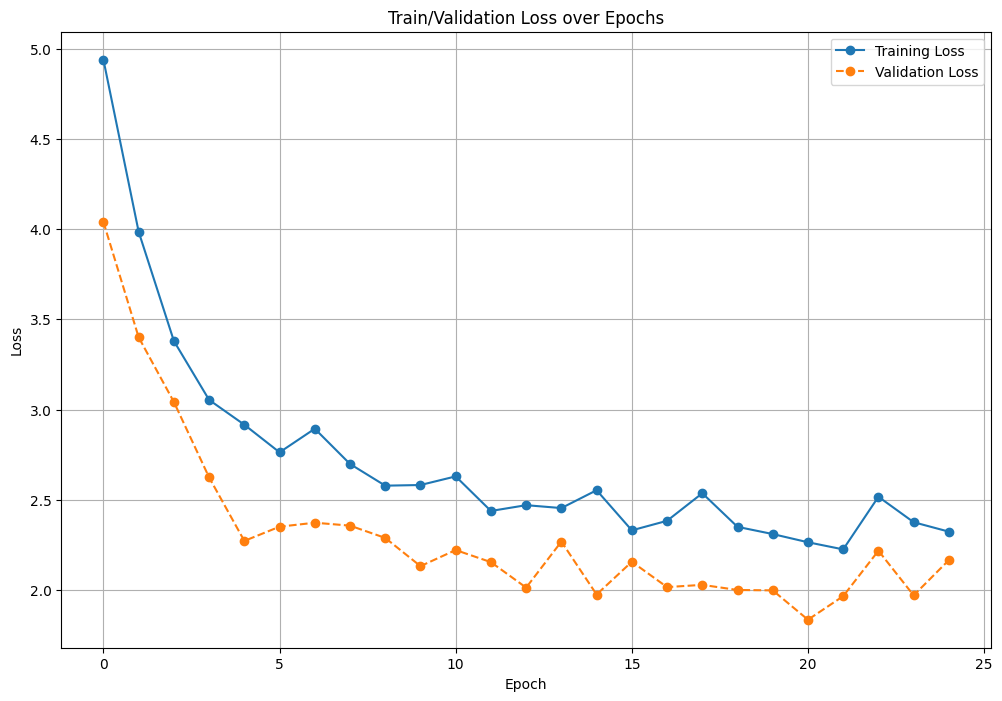

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(history)

plt.figure(figsize=(12, 8))

plt.plot(
    df['epoch'],
    df['train_loss'],
    label='Training Loss',
    marker='o',
    linestyle='-'
)

plt.plot(
    df['epoch'],
    df['test_loss'],
    label='Validation Loss',
    marker='o',
    linestyle='--'
)

plt.title('Train/Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

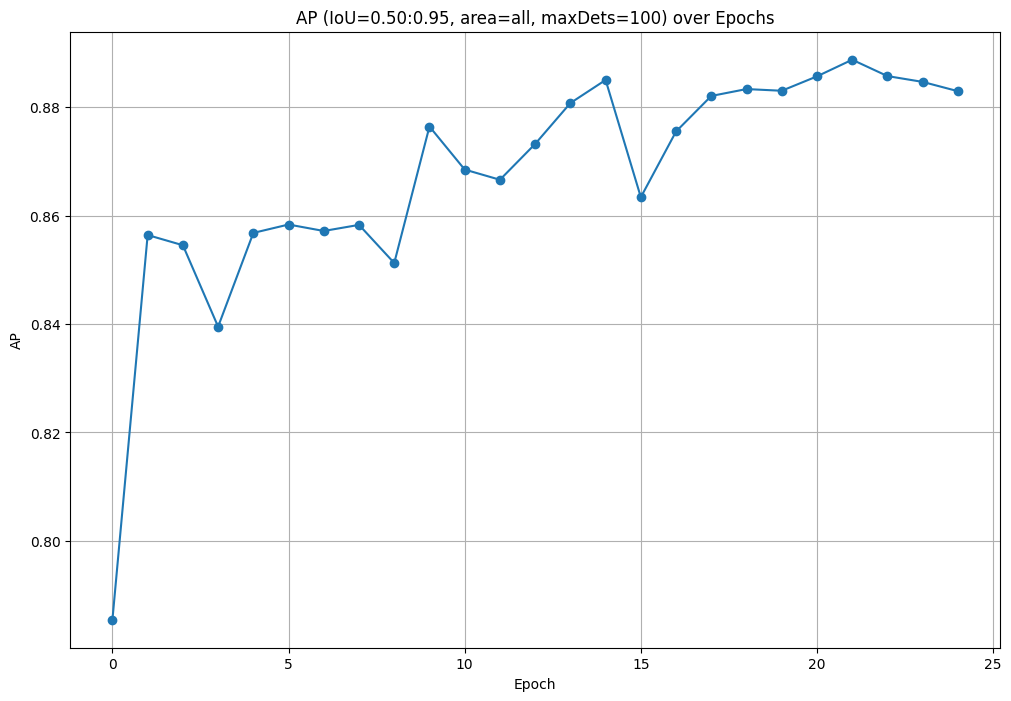

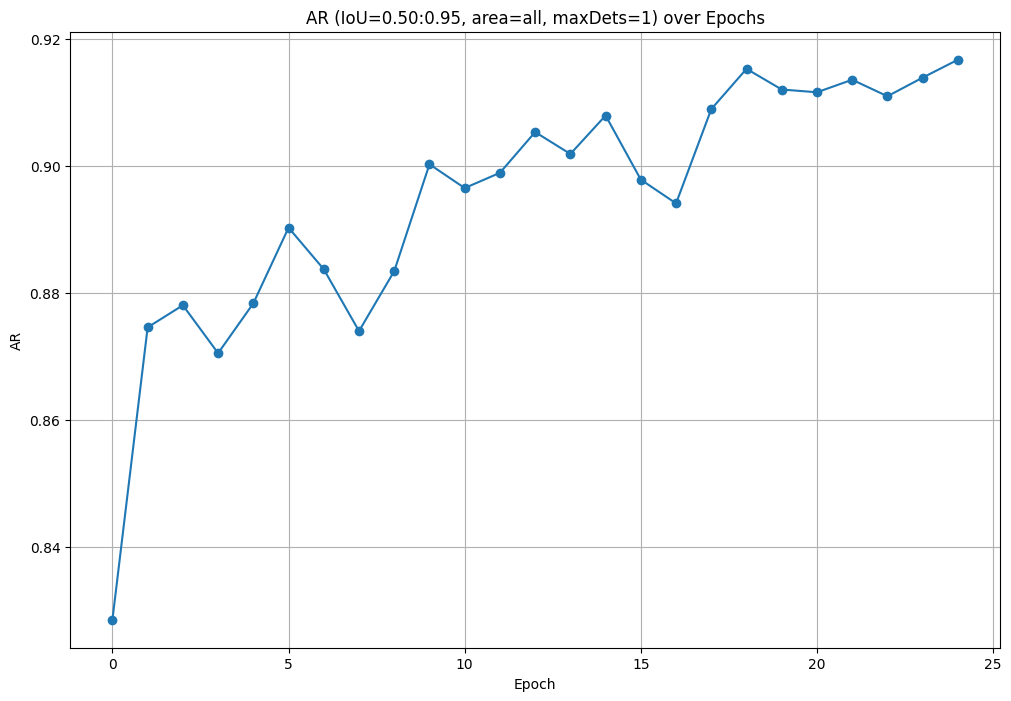

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(history)

df['avg_precision'] = df['test_coco_eval_bbox'].apply(lambda arr: arr[0])
df['avg_recall'] = df['test_coco_eval_bbox'].apply(lambda arr: arr[6])

plt.figure(figsize=(12, 8))
plt.plot(
    df['epoch'],
    df['avg_precision'],
    marker='o',
    linestyle='-'
)
plt.title('AP (IoU=0.50:0.95, area=all, maxDets=100) over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AP')
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 8))
plt.plot(
    df['epoch'],
    df['avg_recall'],
    marker='o',
    linestyle='-'
)
plt.title('AR (IoU=0.50:0.95, area=all, maxDets=1) over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AR')
plt.grid(True)
plt.show()

## Run inference with fine-tuned model

In [7]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

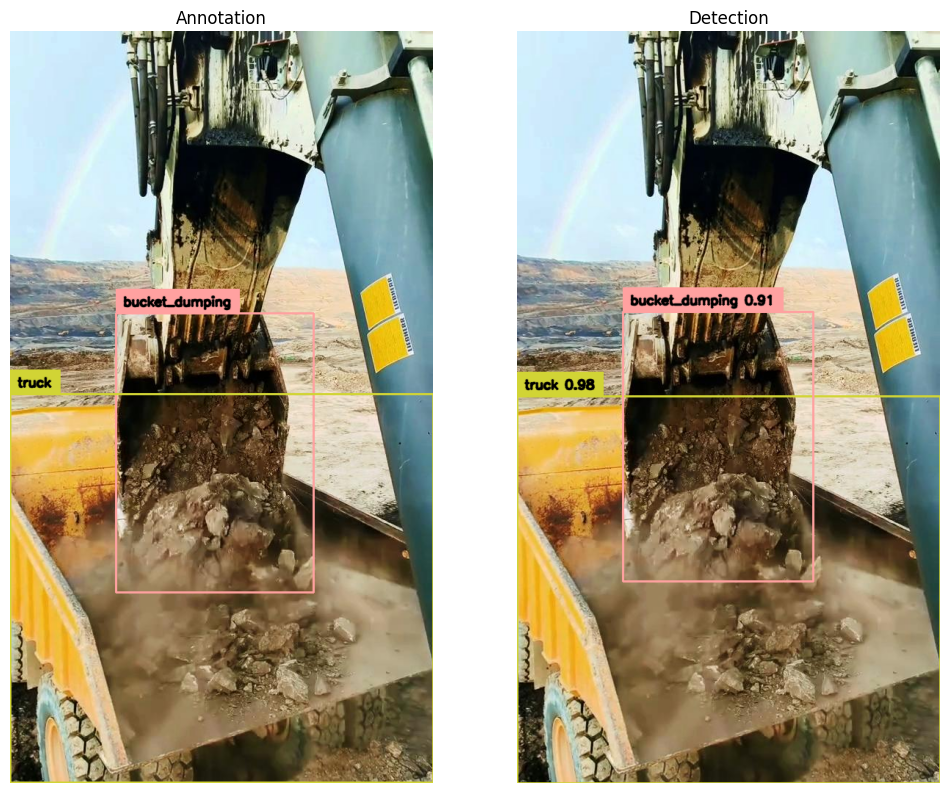

In [8]:
from rfdetr import RFDETRSmall
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_thickness=thickness,
    smart_position=True)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

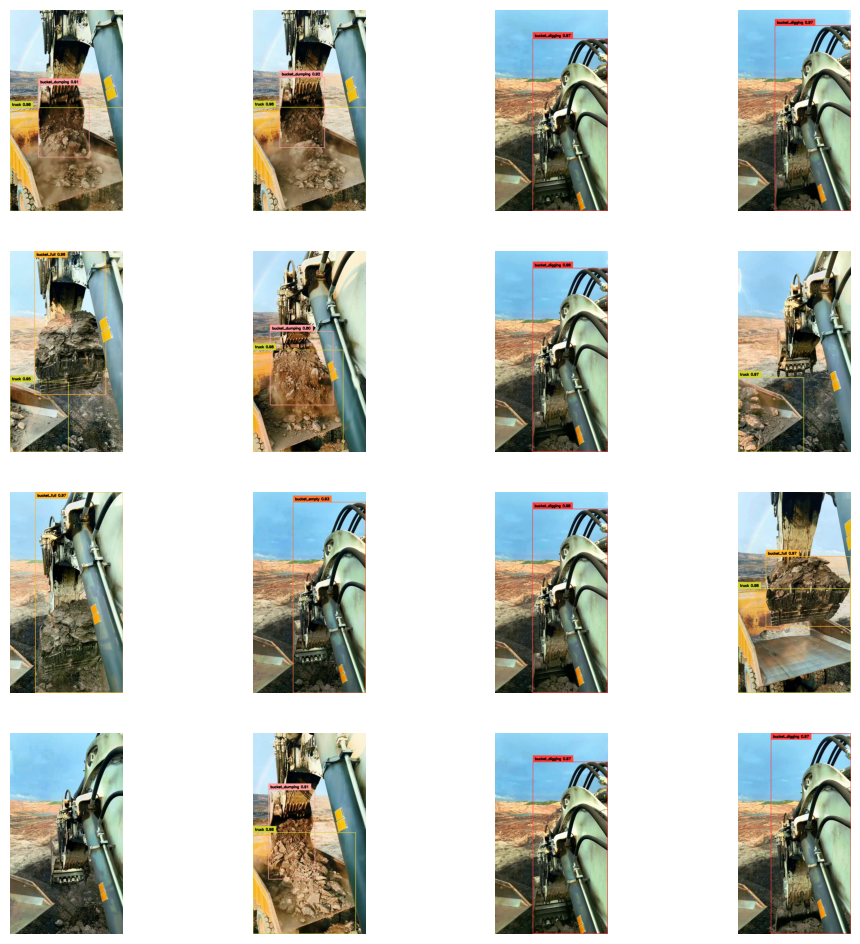

In [9]:
import supervision as sv
from rfdetr import RFDETRSmall
from PIL import Image

detections_images = []

for i in range(16):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = model.predict(image, threshold=0.8)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    bbox_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_thickness=thickness,
        smart_position=True)

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    detections_images.append(detections_image)

sv.plot_images_grid(images=detections_images, grid_size=(4, 4))

In [ ]:
# import supervision as sv
# from rfdetr import RFDETRSmall
# from rfdetr.util.coco_classes import COCO_CLASSES

# model = RFDETRSmall()

# def callback(frame, index):
#     detections = model.predict(frame[:, :, ::-1], threshold=0.7)

#     labels = [
#         f"{COCO_CLASSES[class_id]} {confidence:.2f}"
#         for class_id, confidence
#         in zip(detections.class_id, detections.confidence)
#     ]

#     annotated_frame = frame.copy()
#     annotated_frame = sv.BoxAnnotator().annotate(annotated_frame, detections)
#     annotated_frame = sv.LabelAnnotator().annotate(annotated_frame, detections, labels)
#     return annotated_frame

# sv.process_video(
#     source_path=<SOURCE_VIDEO_PATH>,
#     target_path=<TARGET_VIDEO_PATH>,
#     callback=callback
# )

## Evaluate fine-tuned model

In [ ]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 65/65 [00:02<00:00, 22.40it/s]


In [ ]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.911
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.982
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.946
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = -1.000
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 0.911


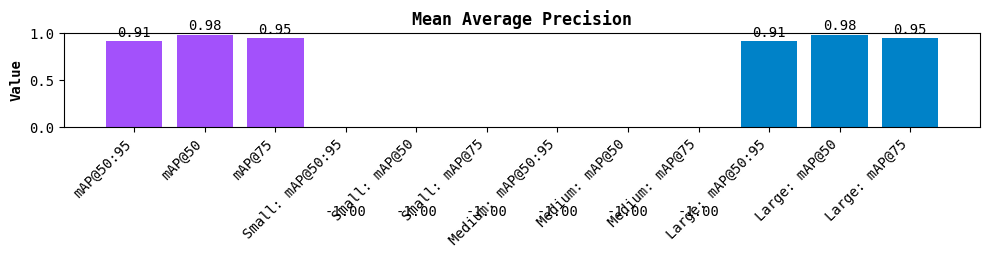

In [ ]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()

map_result.plot()

In [19]:
# confusion_matrix = sv.ConfusionMatrix.from_detections(
#     predictions=predictions,
#     targets=targets,
#     classes=ds.classes
# )

# _ = confusion_matrix.plot()

In [ ]:
from rfdetr import RFDETRNano

# Load model
model = RFDETRNano(pretrain_weights="/content/exavator-detection/checkpoint_best_total.pth")

# Optimasi untuk inference
model.optimize_for_inference()

# Lakukan prediksi
detections = model.predict("/content/frame_0660.jpg")
print(detections)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.


reinitializing detection head with 5 classes


Loading pretrain weights


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Detections(xyxy=array([[1.6347313e-01, 5.1912079e+02, 4.5478064e+02, 1.0222675e+03],
       [8.3837387e+01, 2.5875854e-01, 4.5017523e+02, 7.5712366e+02]],
      dtype=float32), mask=None, confidence=array([0.9657745, 0.9404809], dtype=float32), class_id=array([5, 4]), tracker_id=None, data={}, metadata={})


In [ ]:
# Gunakan Google Drive sebagai backup
from google.colab import drive
drive.mount('/content/drive')

# Copy ke Drive sebelum download
!cp -r /content/exa-detection /content/drive/MyDrive/

In [10]:
import shutil
from google.colab import files

# 1. Kompres folder menjadi zip
shutil.make_archive('/content/exavator-detection', 'zip', '/content/exavator-detection')

# 2. Unduh file zip
files.download('/content/exavator-detection.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Load and run fine-tuned model

In [ ]:
# !pip install rfdetr[onnxexport]

In [ ]:
# from rfdetr import RFDETRSmall

# model = RFDETRSmall(pretrain_weights='/content/exa-detect/C.pth')

# model.export()

In [ ]:
# import supervision as sv
# import numpy as np
# from rfdetr import RFDETRBase
# from rfdetr.util.coco_classes import COCO_CLASSES

# # Inisialisasi model dengan jumlah kelas yang sesuai
# model = RFDETRBase(
#     pretrain_weights="/content/output/checkpoint_best_ema.pth",
#     num_classes=5  # Sesuaikan dengan jumlah kelas di pretrained weights
# )

# # Optimasi model untuk inference (mengatasi warning kedua)
# model.optimize_for_inference()

# # Mapping kelas sesuai dengan dataset Excavator Detection Anda
# CUSTOM_CLASSES = {
#     0: "bucket_digging",
#     1: "bucket_dumping",
#     2: "bucket_empty",
#     3: "bucket_full",
#     4: "truck"
# }

# def callback(frame, index):
#     # SOLUSI 1: Gunakan .copy() untuk mengatasi negative stride
#     # Konversi BGR ke RGB dengan aman
#     rgb_frame = frame[:, :, ::-1].copy()

#     # Alternatif menggunakan cv2 (jika tersedia):
#     # import cv2
#     # rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#     detections = model.predict(rgb_frame, threshold=0.5)

#     # Periksa apakah detections memiliki hasil
#     if len(detections) == 0:
#         return frame

#     # Gunakan kelas custom karena model hanya memiliki 5 kelas
#     labels = [
#         f"{CUSTOM_CLASSES.get(class_id, f'class_{class_id}')} {confidence:.2f}"
#         for class_id, confidence
#         in zip(detections.class_id, detections.confidence)
#     ]

#     annotated_frame = frame.copy()
#     annotated_frame = sv.BoxAnnotator().annotate(annotated_frame, detections)
#     annotated_frame = sv.LabelAnnotator().annotate(annotated_frame, detections, labels)
#     return annotated_frame

# # SOLUSI 2: Tambahkan error handling
# try:
#     sv.process_video(
#         source_path="/content/exavator.mp4",
#         target_path="/content/results.mp4",
#         callback=callback
#     )
#     print("Video processing completed successfully!")
# except Exception as e:
#     print(f"Error during video processing: {e}")

In [ ]:
# from rfdetr import RFDETRSmall

# # Gunakan RFDETRSmall yang kompatibel dengan checkpoint Anda
# model = RFDETRSmall(pretrain_weights="/content/exa-detect/checkpoint_best_total.pth")

# # Export model
# model.export()